### Fugurative Language Resolution: Metaphor Detection

##### Experiment 1: How important are conceptual semantic features such as abstractness scores in metaphor identification?

In [1]:
import numpy as np
import pandas as pd

import fasttext
import fasttext.util

In [5]:
import os
os.getcwd()
os.chdir('/export/home/sdubey')

In [6]:
#Load training data
train_data = pd.read_csv('./FLR/confident_german_train.csv', sep='\t')
#Load test data
test_data = pd.read_csv('./FLR/confident_german_test.csv', sep='\t')

In [4]:
#Three abstractness scores are provided corresponding to each German adjective-noun phrase or metaphor
train_data.head(5)

,an_phrase,an_inflection,en,label,percentage_label,keyword,org_label,context,source,abstractness_noun,abstractness,abstractness_phrase
0,relativ Chaos,relatives Chaos,relative chaos,1,0.8,relativ,lmmmm,"die astrologix -Server müssen (an 1. Juni 13, ...","astrologix.de,http://www.astrologix.de/",3.559,2.975,3.267
1,nötig Änderung,nötige Änderung,necessary change,0,0.0,nötig,lllll,mit eine paar wenig Klick setzen die Shopsoftw...,"gambio.de,http://www.gambio.de/Referenzen.html",3.821,2.474,3.147
2,traditionell Jesuitenfarbe,traditionelle Jesuitenfarbe,traditional Jesuit colour,0,0.0,traditionell,lllll,die optisch Eindruck Schwarz und Silber sollen...,"jesuitenkirche-innsbruck.at,http://jesuitenkir...",4.289,3.607,3.948
3,lokal Marktführer,lokaler Marktführer,local market leader,0,0.0,lokal,lllll,die Gärtnerei Berg sein die lokal Marktführer ...,"bergbinzen.de,http://www.bergbinzen.de/",4.382,3.799,4.090
4,sozial Umfeld,soziales Umfeld,social environment,0,0.2,sozial,llmll,"Stigma, Unwissen, Aberglaube, Intoleranz sie g...","unicef.de,http://www.unicef.de/",3.474,2.871,3.173


##### Data Preparation

In [7]:
#conceptual semantic features
features_train = train_data[['abstractness_noun', 'abstractness', 'abstractness_phrase']]
features_test = test_data[['abstractness_noun', 'abstractness', 'abstractness_phrase']]
#labels: 1- Metaphor  0- Literal
labels_train = train_data['label']
labels_test = test_data['label']

##### Classification using Random Forest

In [8]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=300, random_state=0)

In [9]:
#Training
clf.fit(features_train, labels_train) 

RandomForestClassifier(n_estimators=300, random_state=0)

In [10]:
#Accuracy on test data
clf.score(features_test, labels_test) 

0.7222222222222222

In [11]:
labels_pred = clf.predict(features_test)

In [12]:
#F1-score
from sklearn import metrics
metrics.f1_score(labels_test, labels_pred)

0.396551724137931

##### Experiment 2: How important are lexical semantic features such as word embeddings in metaphor identification?

In [13]:
#load fasttext word embeddings
ft = fasttext.load_model('cc.de.300.bin')

In [14]:
#project word embeddings from 300-dimensional space into 10-dimensional space
fasttext.util.reduce_model(ft, 10)

In [15]:
phrase_train = train_data['an_phrase']
phrase_test = test_data['an_phrase']

In [16]:
phrase_train = phrase_train.values.tolist()
phrase_test = phrase_test.values.tolist()

In [17]:
#Store word embeddings corresponding to each metaphor phrase in German
embeddings_train = []
temp = np.zeros([10,2])
for i in range(len(phrase_train)):
        temp = np.concatenate([ft.get_word_vector(phrase_train[i].split()[0]), ft.get_word_vector(phrase_train[i].split()[1])])
        embeddings_train.append(temp)
        
embeddings_test = []
temp = np.zeros([10,2])
for i in range(len(phrase_test)):
        temp = np.concatenate([ft.get_word_vector(phrase_test[i].split()[0]), ft.get_word_vector(phrase_test[i].split()[1])])
        embeddings_test.append(temp)

In [18]:
#Training
clf.fit(embeddings_train, labels_train)

RandomForestClassifier(n_estimators=300, random_state=0)

In [19]:
#Accuracy on test data
clf.score(embeddings_test, labels_test)

0.8253968253968254

In [20]:
labels_pred = clf.predict(embeddings_test)

In [21]:
#F1 score
from sklearn import metrics
metrics.f1_score(labels_test, labels_pred)

0.6393442622950819

##### Experiment 3: Concatenate lexical and conceptual semantic features.


In [23]:
features_train = features_train.values.tolist()
features_test = features_test.values.tolist()

In [24]:
emb_abs_train = []
for i in range(len(phrase_train)):
        temp = np.hstack((ft.get_word_vector(phrase_train[i].split()[0]), ft.get_word_vector(phrase_train[i].split()[1])))
        temp = np.hstack((temp, features_train[i]))
        emb_abs_train.append(temp)

In [25]:
emb_abs_test = []
for i in range(len(phrase_test)):
        temp = np.hstack((ft.get_word_vector(phrase_test[i].split()[0]), ft.get_word_vector(phrase_test[i].split()[1])))
        temp = np.hstack((temp, features_test[i]))
        emb_abs_test.append(temp)

In [27]:
clf.fit(emb_abs_train, labels_train)

RandomForestClassifier(n_estimators=300, random_state=0)

In [28]:
clf.score(emb_abs_test, labels_test, sample_weight=None)

0.8392857142857143

In [31]:
#F1-score
labels_pred = clf.predict(emb_abs_test)
metrics.f1_score(labels_test, labels_pred)

0.6610878661087868

Conclusion: You can not only rely on abstractness (conceptual features) for metaphor identification, lexical features still matter.

##### Experiment 4: Measuring metaphoricity from word level embeddings.
Compare embeddings learned for individual words in order to determine whether they come from the same domain. This is done by determining similarity between the representations of the two words (adjective-noun pairs) in a phrase.

In [22]:
phrase_train[0].split()[0]

'relativ'

In [23]:
cosine_similarities = []
for i in range(len(phrase_train)):
    cosine_similarities.append(metrics.pairwise.cosine_similarity(ft.get_word_vector(phrase_train[i].split()[0]).reshape(1, -1), ft.get_word_vector(phrase_train[i].split()[1]).reshape(1, -1)))


In [30]:
len(cosine_similarities)

1173

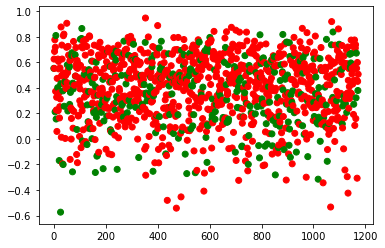

In [48]:
import matplotlib.pyplot as plt
color= ['red' if l == 0 else 'green' for l in labels_train]
plt.scatter(range(len(cosine_similarities)), cosine_similarities, color=color)

In [190]:
from scipy.optimize import minimize

In [75]:
cosine_similarities[0][0][0]

0.55235326

In [36]:
train_data.insert(12, "cosine similarity", cosine_similarities[])

In [134]:
train_data_subset = train_data.sample(n=100,axis='rows')

In [135]:
train_data_subset = train_data_subset.reset_index()

In [260]:
tp_max = 0
tp_old = 0
for x in range(-5,10):
    #print(x)
    tp = 0
    for i in range (1173):
        if train_data['cosine similarity'][i][0][0] > x and train_data['label'][i] == 0:
            tp+=1
        elif train_data['cosine similarity'][i][0][0] <= x and train_data['label'][i] == 1:
            tp+=1
    print(tp)
    if tp>tp_max:
        print(tp)
        tp_max = tp
        threshold = x
    tp_old = tp
        
    

839
839
839
839
839
839
807
334
334
334
334
334
334
334
334
334


In [236]:
threshold

-5

In [243]:
tp_max/1173

0.7152600170502984

In [253]:
from scipy.optimize import minimize_scalar

def objective_function(x):
    tp = 0
    for i in range (1173):
        if train_data['cosine similarity'][i][0][0] > x and train_data['label'][i] == 0:
            tp+=1
        if train_data['cosine similarity'][i][0][0] <= x and train_data['label'][i] == 1:
            tp+=1
    return 1173/tp

In [254]:
res = minimize_scalar(objective_function, method='bounded', bounds=(np.min(cosine_similarities), np.max(cosine_similarities)))

In [255]:
res

     fun: 1.399761336515513
 message: 'Solution found.'
    nfev: 27
  status: 0
 success: True
       x: -0.5205666714988805

In [257]:
1/res['fun']

0.7144075021312873

The thres.hold values of cosine similarities can lie between -0.5 to 0 to obtain an accuracy of 71.44%